# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [ ]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl


### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [ ]:
#NOTE Change the data directory according to where you have your zarr files stored
import copy

config_base = {
    "data": {
        "path": "/content/cse-151B-Competition/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 120,
        "batch_size": 64,
        "num_workers": 4,
    },
    "model": {
        "type": "simple_cnn",
        "kernel_size": 3,
        "init_dim": 64,
        "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3,
    },
    "trainer": {
        # "max_epochs": 10, # Will be overridden per experiment if needed
        "accelerator": "auto",
        "devices": "auto",
        "precision": 32, # Consider '16-mixed' for larger models if OOM persists
        "deterministic": True,
        "num_sanity_val_steps": 0,
        "log_every_n_steps": 10, # Log more frequently
    },
    "seed": 42,
}

# --- Experiment Configurations ---
experiment_configs = []

# Original experiment
config_original = copy.deepcopy(config_base)
config_original["trainer"]["max_epochs"] = 10
config_original["experiment_name"] = "OriginalBaseline_lr1e-3_epochs10"
experiment_configs.append(config_original) # Optionally run this

# Experiment 1: Deeper CNN (OOM candidate)
config_exp1 = copy.deepcopy(config_base)
config_exp1["model"]["depth"] = 6
config_exp1["trainer"]["max_epochs"] = 10 # or more if it runs
config_exp1["data"]["batch_size"] = 16 # <<<< REDUCED BATCH SIZE
config_exp1["experiment_name"] = "DeeperCNN_Depth6_BS16"
#experiment_configs.append(config_exp1)

# Experiment 2: Wider CNN 
config_exp2["model"]["init_dim"] = 128
config_exp2["trainer"]["max_epochs"] = 10
config_exp2["experiment_name"] = "WiderCNN_InitDim128_lr1e-3_epochs10"
#experiment_configs.append(config_exp2) # Already run

# Experiment 3: Lower Learning Rate and More Epochs
config_exp3 = copy.deepcopy(config_base)
config_exp3["training"]["lr"] = 1e-4
config_exp3["trainer"]["max_epochs"] = 30 # <<<< INCREASED EPOCHS
config_exp3["experiment_name"] = "LowerLR_1e-4_Epochs30_ScheduledLR"
#experiment_configs.append(config_exp3)

# Experiment 4: Higher Dropout
config_exp4 = copy.deepcopy(config_base)
config_exp4["model"]["dropout_rate"] = 0.2
config_exp4["trainer"]["max_epochs"] = 10
config_exp4["experiment_name"] = "HigherDropout_0.2_lr1e-3_epochs10"
#experiment_configs.append(config_exp4)

# Experiment 5: Deeper and Wider CNN (OOM candidate)
config_exp5 = copy.deepcopy(config_base)
config_exp5["model"]["depth"] = 5
config_exp5["model"]["init_dim"] = 96
config_exp5["trainer"]["max_epochs"] = 10 # or more if it runs
config_exp5["data"]["batch_size"] = 16 # <<<< REDUCED BATCH SIZE
config_exp5["experiment_name"] = "Deeper5_Wider96_CNN_BS16"
#experiment_configs.append(config_exp5)


### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [ ]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**.

We encourage you to build and experiment with your own models and ideas.


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride), nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(identity)
        return self.relu(out)

class SimpleCNN(nn.Module):
    def __init__(self, n_input_channels, n_output_channels, kernel_size=3, init_dim=64, depth=4, dropout_rate=0.2):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(n_input_channels, init_dim, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(init_dim),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.ModuleList()
        current_dim = init_dim
        for i in range(depth):
            out_dim = current_dim * 2 if i < depth - 1 else current_dim
            self.res_blocks.append(ResidualBlock(current_dim, out_dim))
            if i < depth - 1:
                current_dim *= 2
        self.dropout = nn.Dropout2d(dropout_rate)
        self.final = nn.Sequential(
            nn.Conv2d(current_dim, current_dim // 2, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(current_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(current_dim // 2, n_output_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.initial(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        return self.final(self.dropout(x))


### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [ ]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [ ]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id, # This is used for training and validation member
        val_split=0.1,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()
        self.lat = None
        self.lon = None
        self.area_weights = None

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        # Define spatial_template based on a representative, member-agnostic slice if possible
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)
        if "latitude" in spatial_template.dims: # Ensure template uses y,x
            spatial_template = spatial_template.rename({"latitude": "y", "longitude": "x"})


        # Helper function to load data for a specific SSP and member ID
        def load_ssp_member(ssp_str, member_id_to_load):
            input_dask_member, output_dask_member = [], []
            for var_name in self.input_vars:
                da_var_ssp = ds[var_name].sel(ssp=ssp_str)

                current_da_var = da_var_ssp # Start with SSP-level data
                if "latitude" in current_da_var.dims: # Standardize spatial dim names early
                    current_da_var = current_da_var.rename({"latitude": "y", "longitude": "x"})

                if "member_id" in current_da_var.dims:
                    current_da_var = current_da_var.sel(member_id=member_id_to_load)
                # If no member_id dim, current_da_var (already SSP-selected) is used

                if set(current_da_var.dims) == {"time"}: # Non-spatial variable
                    current_da_var = current_da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask_member.append(current_da_var.data)

            for var_name in self.output_vars:
                da_out_member = ds[var_name].sel(ssp=ssp_str, member_id=member_id_to_load)
                if "latitude" in da_out_member.dims:
                    da_out_member = da_out_member.rename({"latitude": "y", "longitude": "x"})
                output_dask_member.append(da_out_member.data)

            return da.stack(input_dask_member, axis=1), da.stack(output_dask_member, axis=1)

        # --- Training and Validation Data Preparation ---
        # Uses self.target_member_id for training and validation source (ssp370)
        train_input_list, train_output_list = [], []
        val_input_ssp370_member, val_output_ssp370_member = None, None

        for ssp_name in self.train_ssps:
            x_ssp, y_ssp = load_ssp_member(ssp_name, self.target_member_id)

            if ssp_name == "ssp370": # ssp370 is used for validation split
                val_input_ssp370_member = x_ssp[-self.test_months:]
                val_output_ssp370_member = y_ssp[-self.test_months:]
                train_input_list.append(x_ssp[:-self.test_months])
                train_output_list.append(y_ssp[:-self.test_months])
            else:
                train_input_list.append(x_ssp)
                train_output_list.append(y_ssp)

        train_input_agg = da.concatenate(train_input_list, axis=0)
        train_output_agg = da.concatenate(train_output_list, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input_agg, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input_agg, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output_agg, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output_agg, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input_agg, "input")
        train_output_norm = self.normalizer.normalize(train_output_agg, "output")

        val_input_norm = self.normalizer.normalize(val_input_ssp370_member, "input")
        val_output_norm = self.normalizer.normalize(val_output_ssp370_member, "output")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)

        # --- Test Data Preparation (Processes all 3 members for self.test_ssp) ---
        all_test_inputs_norm_list = []
        all_test_outputs_list = [] # These are the "corrupted" ground truths

        num_ensemble_members_for_test = 3

        for m_id in range(num_ensemble_members_for_test):
            print(f"Loading test data for {self.test_ssp}, member_id: {m_id}")
            test_input_single_member, test_output_single_member = load_ssp_member(self.test_ssp, m_id)

            # Ensure we take the correct number of months from the end
            test_input_single_member = test_input_single_member[-self.test_months:]
            test_output_single_member = test_output_single_member[-self.test_months:]

            test_input_single_member_norm = self.normalizer.normalize(test_input_single_member, "input")

            all_test_inputs_norm_list.append(test_input_single_member_norm)
            all_test_outputs_list.append(test_output_single_member)

        final_test_input_all_members_norm = da.concatenate(all_test_inputs_norm_list, axis=0)
        final_test_output_all_members = da.concatenate(all_test_outputs_list, axis=0)

        self.test_dataset = ClimateDataset(final_test_input_all_members_norm, final_test_output_all_members, output_is_normalized=False)

        # --- Set coordinates and area weights ---
        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True, persistent_workers=self.num_workers > 0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True, persistent_workers=self.num_workers > 0)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True, persistent_workers=self.num_workers > 0)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [ ]:
import copy
#import pytorch_lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import xarray as xr
import pandas as pd
import os
from datetime import datetime

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model'])
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
            self.normalizer = self.trainer.datamodule.normalizer


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)
        return loss

    def on_validation_epoch_end(self):
        if not self.val_preds:
             if self.trainer.sanity_checking: return
             print("Warning: val_preds is empty in on_validation_epoch_end. Skipping evaluation.")
             return

        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        # np.save("val_preds.npy", preds)
        # np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.normalizer = self.trainer.datamodule.normalizer


        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        if not self.test_preds:
            print("Warning: test_preds is empty in on_test_epoch_end. Skipping submission.")
            return
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/loss",
                "interval": "epoch",
                "frequency": 1,
            }
        }

    # _evaluate method correctly indented here
    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        # Ensure datamodule is fully setup, especially for coords and weights
        if not hasattr(datamodule, 'output_vars') or not datamodule.output_vars:
            print(f"Warning: datamodule.output_vars not set or empty in _evaluate for phase {phase}.")
            # Attempt to use hparams if available, otherwise use a default or skip
            output_vars = self.hparams.get('output_vars', ['tas', 'pr']) # Fallback
        else:
            output_vars = datamodule.output_vars

        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])


        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            }, on_epoch=True)

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        if not hasattr(datamodule, 'output_vars') or not datamodule.output_vars:
            print(f"Warning: datamodule.output_vars not set or empty in _save_submission.")
            output_vars = self.hparams.get('output_vars', ['tas', 'pr']) # Fallback
        else:
            output_vars = datamodule.output_vars

        lat, lon = datamodule.get_coords()
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t_val in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y_val in enumerate(lat):
                    for x_idx, x_val in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y_val:.2f}_{x_val:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)

        exp_name_for_file = "submission" # Default
        if self.trainer and self.trainer.logger and hasattr(self.trainer.logger, 'name') and self.trainer.logger.name:
            exp_name_for_file = self.trainer.logger.name
        elif 'experiment_name' in self.hparams:
             exp_name_for_file = self.hparams.experiment_name

        filepath = f"submissions/kaggle_{exp_name_for_file}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")




### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [ ]:
for i, current_config in enumerate(experiment_configs):
    experiment_name = current_config.get('experiment_name', f'Experiment_{i+1}')
    print(f"\nRunning {experiment_name}...")
    print("Current configuration:")
    for key, value in current_config.items():
        print(f"  {key}: {value}")


    pl.seed_everything(current_config["seed"], workers=True)

    datamodule = ClimateDataModule(**current_config["data"])

    model = SimpleCNN(
        n_input_channels=len(current_config["data"]["input_vars"]),
        n_output_channels=len(current_config["data"]["output_vars"]),
        **{k: v for k, v in current_config["model"].items() if k != "type"}
    )

    lightning_module = ClimateEmulationModule(model, learning_rate=current_config["training"]["lr"])

    # Setup ModelCheckpoint to save the best model based on validation loss
    checkpoint_callback = ModelCheckpoint(
        monitor="val/loss",
        dirpath=f"checkpoints/{experiment_name}",
        filename=f"{experiment_name}-best-{{epoch:02d}}-{{val/loss:.4f}}",
        save_top_k=1,
        mode="min",
    )

    # Consider adding a logger
    from lightning.pytorch.loggers import TensorBoardLogger
    logger = TensorBoardLogger("tb_logs", name=experiment_name)

    trainer_args = {**current_config["trainer"]} # Make a mutable copy
    if "max_epochs" not in trainer_args: # Ensure max_epochs is set from config_base if not overridden
        trainer_args["max_epochs"] = config_base["trainer"].get("max_epochs", 10)


    trainer = pl.Trainer(
        **trainer_args,
        callbacks=[checkpoint_callback],
        logger=logger
    )

    print(f"Starting training for {experiment_name}...")
    try:
        trainer.fit(lightning_module, datamodule=datamodule)
        print(f"Training finished for {experiment_name}.")


    except Exception as e:
        print(f"CAUGHT Exception for {experiment_name}: {e}")
        if "CUDA out of memory" in str(e):
            print(f"Consider further reducing batch_size or model complexity for {experiment_name}.")
        # Potentially log the error or save partial results if needed

    print(f"--- {experiment_name} complete ---")

print("\nAll specified experiments finished or attempted.")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



Running OriginalBaseline_lr1e-3_epochs10...
Current configuration:
  data: {'path': '/content/cse-151B-Competition/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr', 'input_vars': ['CO2', 'SO2', 'CH4', 'BC', 'rsdt'], 'output_vars': ['tas', 'pr'], 'target_member_id': 0, 'train_ssps': ['ssp126', 'ssp370', 'ssp585'], 'test_ssp': 'ssp245', 'test_months': 120, 'batch_size': 64, 'num_workers': 4}
  model: {'type': 'simple_cnn', 'kernel_size': 3, 'init_dim': 64, 'depth': 4, 'dropout_rate': 0.1}
  training: {'lr': 0.001}
  trainer: {'accelerator': 'auto', 'devices': 'auto', 'precision': 32, 'deterministic': True, 'num_sanity_val_steps': 0, 'log_every_n_steps': 10, 'max_epochs': 10}
  seed: 42
  experiment_name: OriginalBaseline_lr1e-3_epochs10
Starting training for OriginalBaseline_lr1e-3_epochs10...
Creating dataset with 2943 samples...
Creating dataset with 120 samples...
Loading test data for ssp245, member_id: 0
Load

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | SimpleCNN | 10.7 M | train
1 | criterion | MSELoss   | 0      | train
------------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params
42.923    Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | SimpleCNN | 10.7 M | train
1 | criterion | MSELoss   | 0      | train
------------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params
42.923    Total estimated model params size (MB)
47        Modules in train mode
0    

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=12.2211, Time-Mean RMSE=10.3210, Time-Stddev MAE=3.3555
[VAL] pr: RMSE=3.4980, Time-Mean RMSE=2.0878, Time-Stddev MAE=1.8873


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.8682, Time-Mean RMSE=5.3799, Time-Stddev MAE=2.7898
[VAL] pr: RMSE=3.2536, Time-Mean RMSE=1.6504, Time-Stddev MAE=1.7088


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.9468, Time-Mean RMSE=5.7294, Time-Stddev MAE=1.4636
[VAL] pr: RMSE=3.1795, Time-Mean RMSE=1.5935, Time-Stddev MAE=1.6677


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.6605, Time-Mean RMSE=4.2839, Time-Stddev MAE=1.4238
[VAL] pr: RMSE=2.9804, Time-Mean RMSE=1.2513, Time-Stddev MAE=1.6275


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.9925, Time-Mean RMSE=3.5040, Time-Stddev MAE=1.1948
[VAL] pr: RMSE=2.8674, Time-Mean RMSE=1.0481, Time-Stddev MAE=1.5234


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.0537, Time-Mean RMSE=3.5300, Time-Stddev MAE=1.4625
[VAL] pr: RMSE=2.7792, Time-Mean RMSE=0.8416, Time-Stddev MAE=1.5121


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7432, Time-Mean RMSE=3.2949, Time-Stddev MAE=1.2455
[VAL] pr: RMSE=2.7483, Time-Mean RMSE=0.8040, Time-Stddev MAE=1.4835


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7556, Time-Mean RMSE=3.3950, Time-Stddev MAE=1.0438
[VAL] pr: RMSE=2.7590, Time-Mean RMSE=0.8668, Time-Stddev MAE=1.4482


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5228, Time-Mean RMSE=3.2097, Time-Stddev MAE=1.0369
[VAL] pr: RMSE=2.7137, Time-Mean RMSE=0.8061, Time-Stddev MAE=1.4267


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3320, Time-Mean RMSE=3.0226, Time-Stddev MAE=1.0461
[VAL] pr: RMSE=2.6576, Time-Mean RMSE=0.6189, Time-Stddev MAE=1.4126


INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Training finished for OriginalBaseline_lr1e-3_epochs10.
--- OriginalBaseline_lr1e-3_epochs10 complete ---

All specified experiments finished or attempted.


# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [ ]:
config_to_test = config_exp1 # Use the config of the 'DeeperCNN_Depth6_BS16' experiment

checkpoint_path = "checkpoints/DeeperCNN_Depth6_BS16/DeeperCNN_Depth6_BS16-best-epoch=09-val/loss=0.1947.ckpt"

print(f"Attempting to test model from config: {config_to_test.get('experiment_name', 'N/A')}")
print(f"Using checkpoint: {checkpoint_path}")

if not os.path.exists(checkpoint_path):
    print(f"ERROR: Checkpoint file not found at {checkpoint_path}")
    print("Please verify the path to the checkpoint file.")

    experiment_name_for_path = config_to_test.get('experiment_name', 'UNKNOWN_EXPERIMENT')
    expected_checkpoint_dir = f"checkpoints/{experiment_name_for_path}"

    print(f"Expected checkpoint directory: {expected_checkpoint_dir}")
    if os.path.exists(expected_checkpoint_dir):
        print(f"Files in '{expected_checkpoint_dir}':")
        try:
            for f_name in os.listdir(expected_checkpoint_dir):
                print(f"  - {f_name}")
        except Exception as e:
            print(f"    Could not list files: {e}")
    else:
        print(f"The directory '{expected_checkpoint_dir}' was not found.")
        # Check if the parent 'checkpoints' directory exists
        if os.path.exists("checkpoints"):
            print("Files/Folders in parent 'checkpoints/' directory:")
            try:
                for f_name in os.listdir("checkpoints"):
                    print(f"  - {f_name}")
            except Exception as e:
                print(f"    Could not list files: {e}")
        else:
            print("Parent 'checkpoints/' directory also not found.")
    lightning_module_test = None # Ensure it's None if checkpoint not found
else:
    pl.seed_everything(config_to_test["seed"], workers=True)

    # 1. Initialize DataModule
    datamodule_test = ClimateDataModule(**config_to_test["data"])

    # 2. Initialize Model architecture (must match the checkpoint)
    model_for_test = SimpleCNN(
        n_input_channels=len(config_to_test["data"]["input_vars"]),
        n_output_channels=len(config_to_test["data"]["output_vars"]),
        **{k: v for k, v in config_to_test["model"].items() if k != "type"}
    )

    try:
        lightning_module_test = ClimateEmulationModule.load_from_checkpoint(
            checkpoint_path,
            model=model_for_test,
        )
        print(f"Successfully loaded model from checkpoint: {checkpoint_path}")
    except Exception as e:
        print(f"ERROR loading checkpoint: {e}")
        print("Ensure the model architecture in `SimpleCNN` matches the one used for training this checkpoint.")
        print("Also ensure all necessary hparams for `ClimateEmulationModule` are available or can be inferred from the checkpoint.")
        lightning_module_test = None

if lightning_module_test:
    # 3. Initialize Trainer
    trainer_test_args = {**config_to_test["trainer"]}
    trainer_test_args.pop("max_epochs", None)
    trainer_test_args.pop("num_sanity_val_steps", None)
    trainer_test_args.pop("log_every_n_steps", None)
    # trainer_test_args["logger"] = None # Optional: disable logger for testing

    trainer_test = pl.Trainer(**trainer_test_args)

    # 4. Run testing
    print(f"Starting testing for {config_to_test.get('experiment_name', 'N/A')}...")
    try:
        trainer_test.test(lightning_module_test, datamodule=datamodule_test)
        print(f"Testing finished and submission file should be generated for {config_to_test.get('experiment_name', 'N/A')}.")
    except Exception as e:
        print(f"ERROR during trainer.test: {e}")


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Attempting to test model from config: DeeperCNN_Depth6_BS16
Using checkpoint: checkpoints/DeeperCNN_Depth6_BS16/DeeperCNN_Depth6_BS16-best-epoch=09-val/loss=0.1947.ckpt


INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Successfully loaded model from checkpoint: checkpoints/DeeperCNN_Depth6_BS16/DeeperCNN_Depth6_BS16-best-epoch=09-val/loss=0.1947.ckpt
Starting testing for DeeperCNN_Depth6_BS16...
Creating dataset with 2943 samples...
Creating dataset with 120 samples...
Loading test data for ssp245, member_id: 0
Loading test data for ssp245, member_id: 1
Loading test data for ssp245, member_id: 2
Creating dataset with 360 samples...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=291.7502, Time-Mean RMSE=291.7179, Time-Stddev MAE=3.1437
[TEST] pr: RMSE=4.1772, Time-Mean RMSE=3.8150, Time-Stddev MAE=1.2174
✅ Submission saved to: submissions/kaggle_lightning_logs_20250518_094901.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.177192687988281     │
│  test/pr/time_mean_rmse   │     3.814984083175659     │
│   test/pr/time_std_mae    │    1.2173620462417603     │
│       test/tas/rmse       │    291.75018310546875     │
│  test/tas/time_mean_rmse  │     291.7178955078125     │
│   test/tas/time_std_mae   │     3.143721103668213     │
└───────────────────────────┴───────────────────────────┘

Testing finished and submission file should be generated for DeeperCNN_Depth6_BS16.


### Plotting Utils


In [ ]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


Running datamodule.setup() for plotting cell...
Creating dataset with 2943 samples...
Creating dataset with 120 samples...
Creating dataset with 120 samples...
Plotting for output variables: ['tas', 'pr']
Processing variable: tas
Plotting Time-Mean for tas...


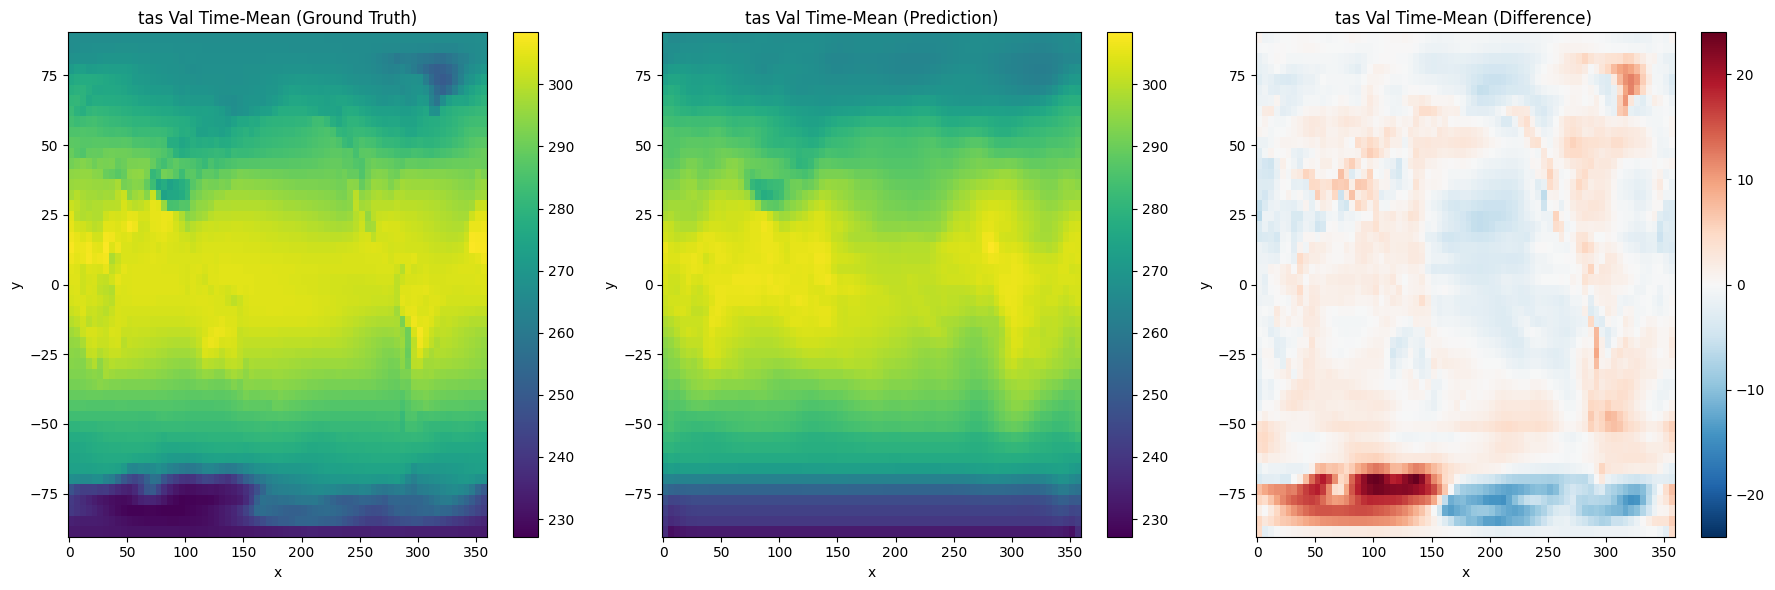

Plotting Time-Stddev for tas...


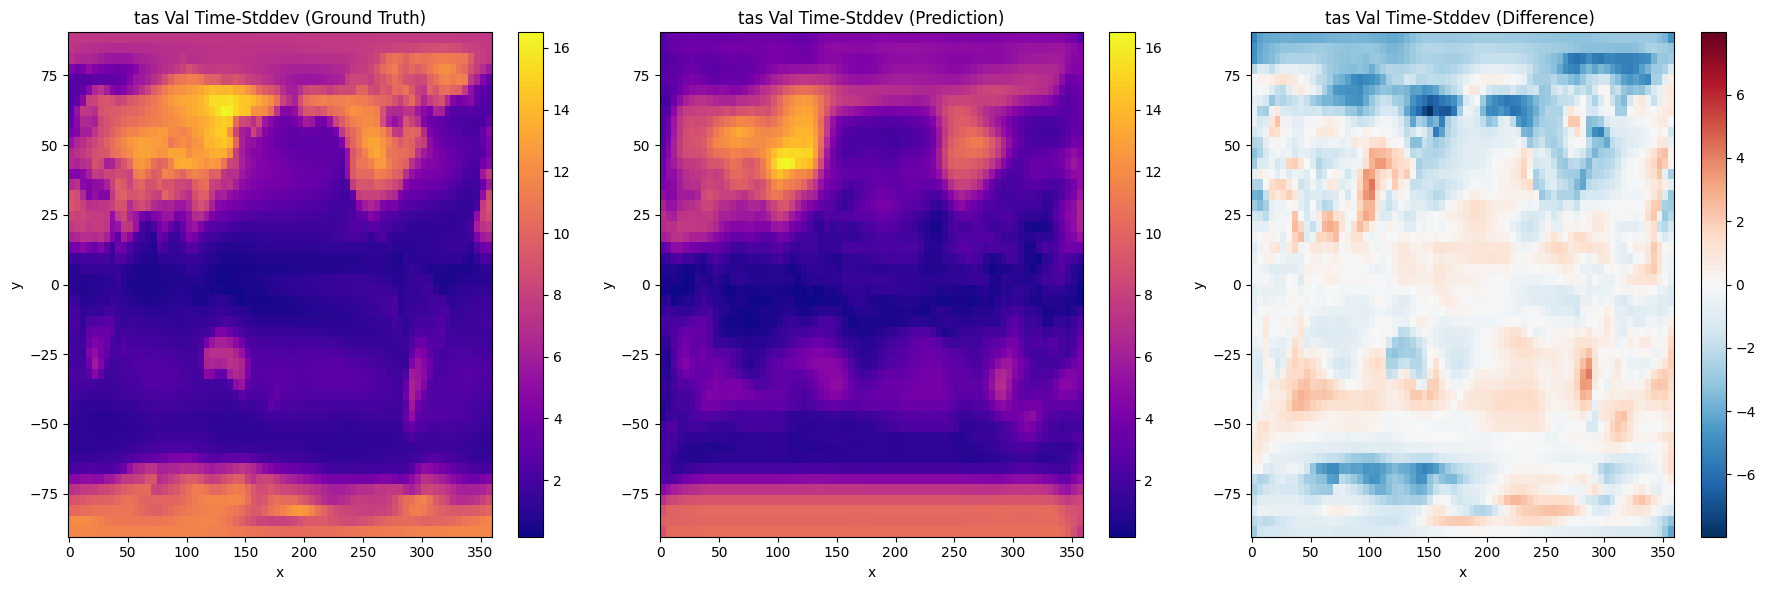

Plotting Random Timestep 102 for tas...


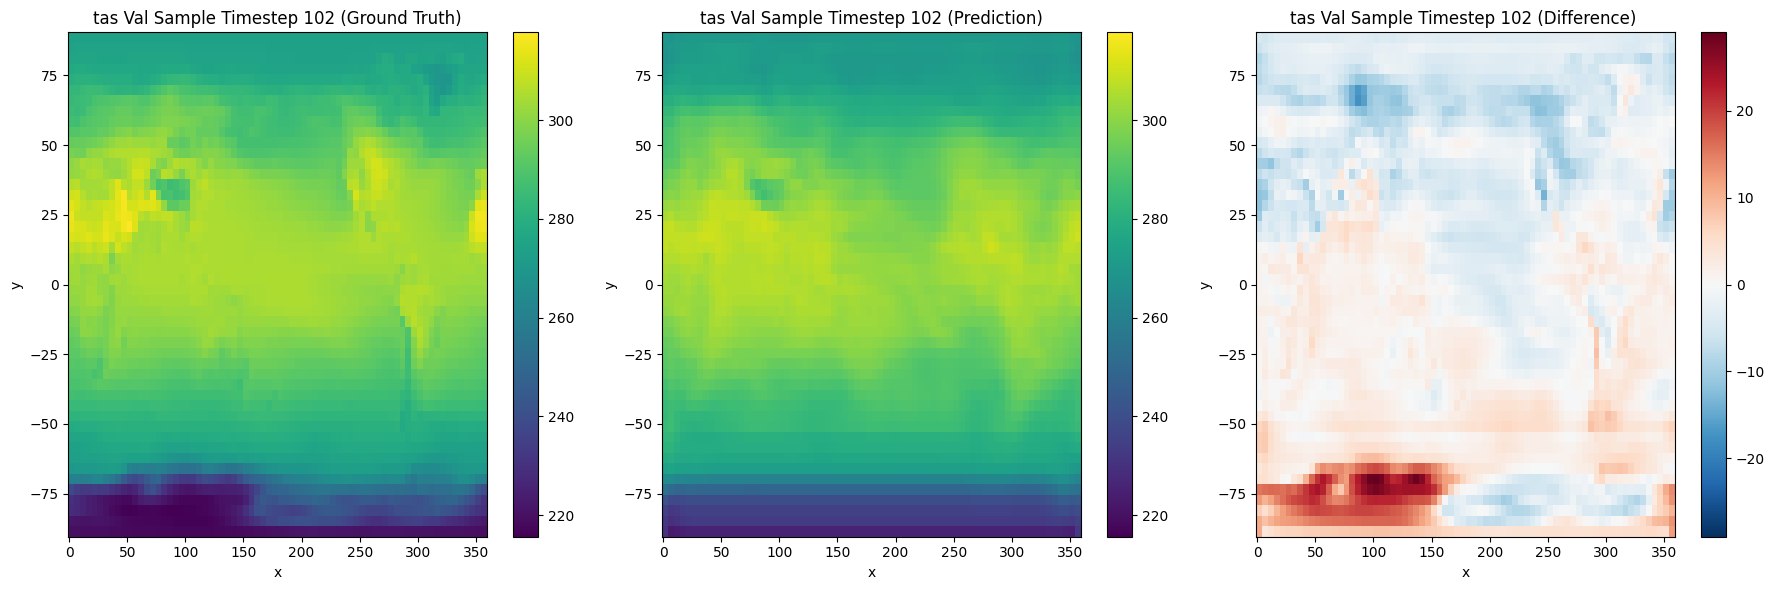

Processing variable: pr
Plotting Time-Mean for pr...


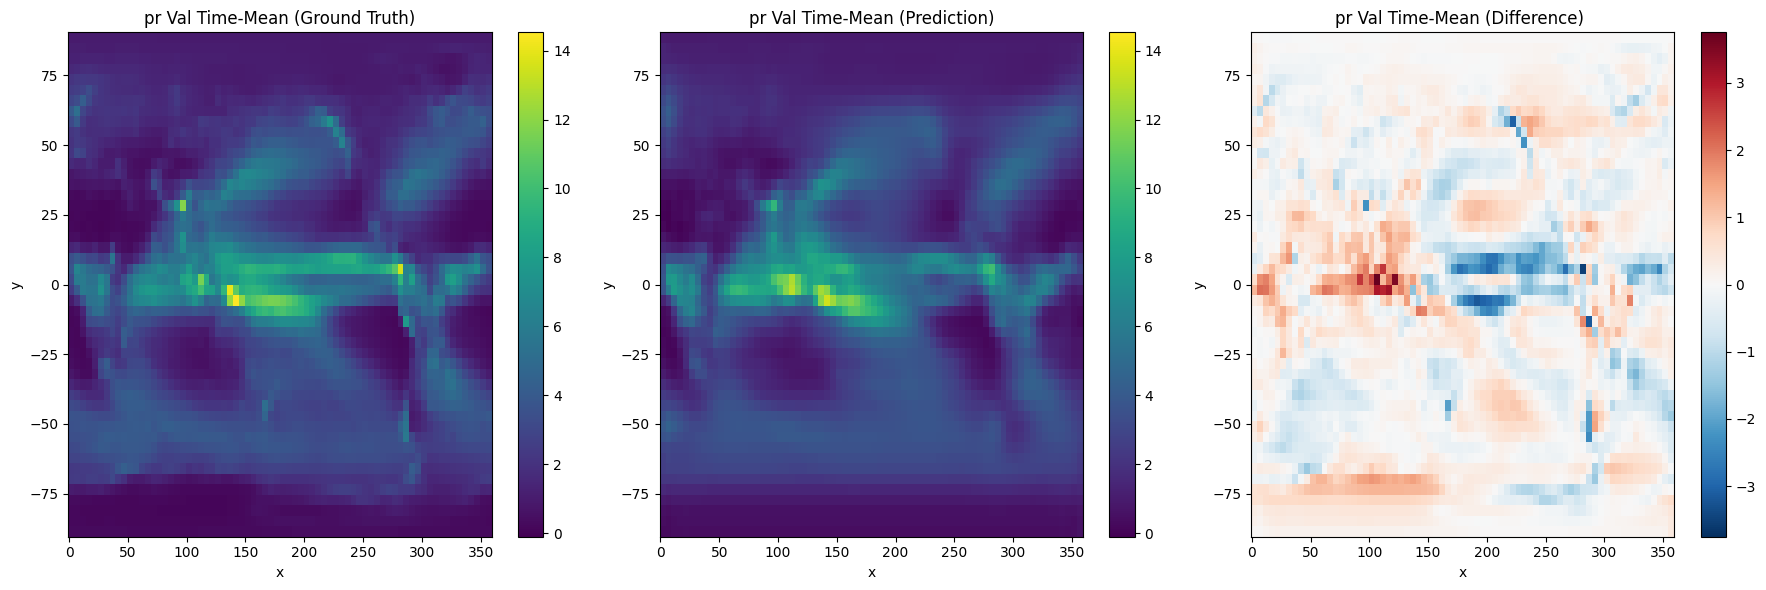

Plotting Time-Stddev for pr...


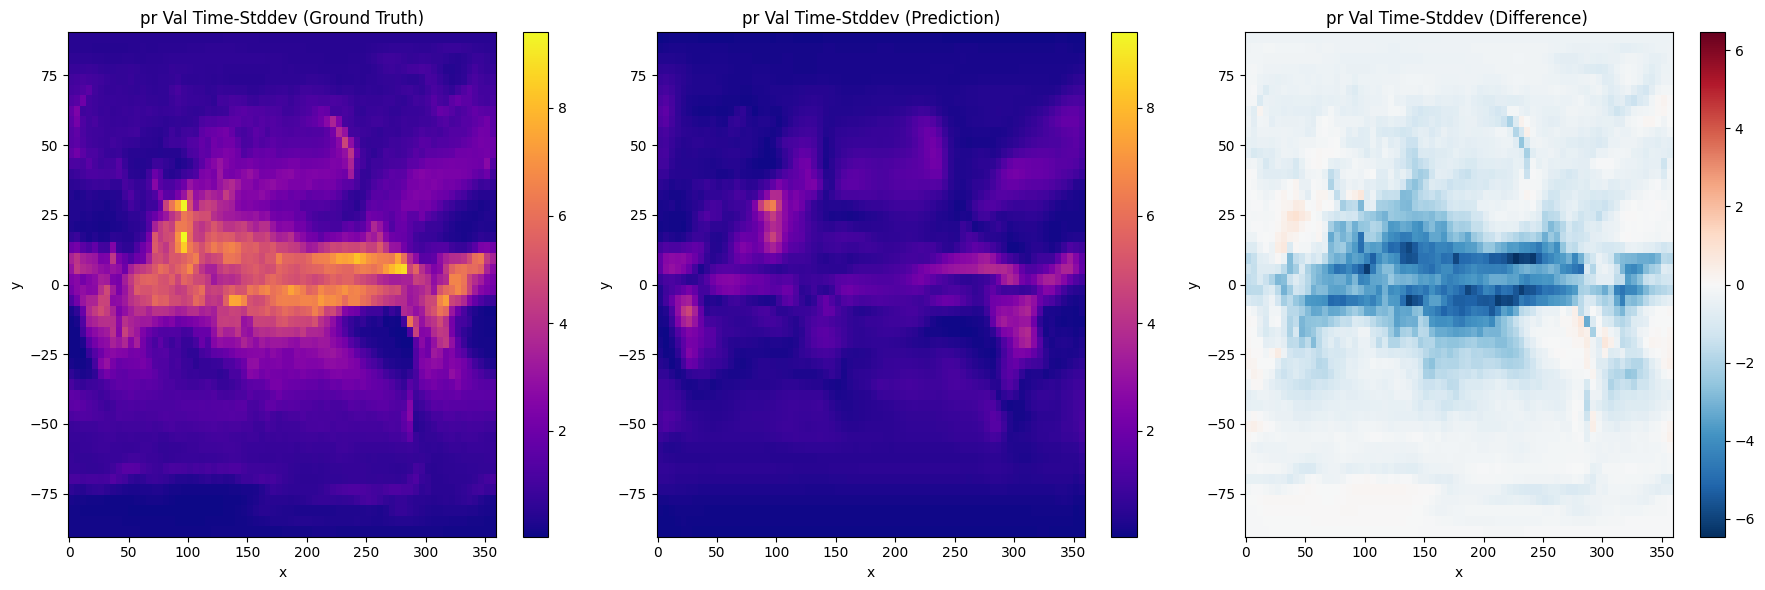

Plotting Random Timestep 51 for pr...


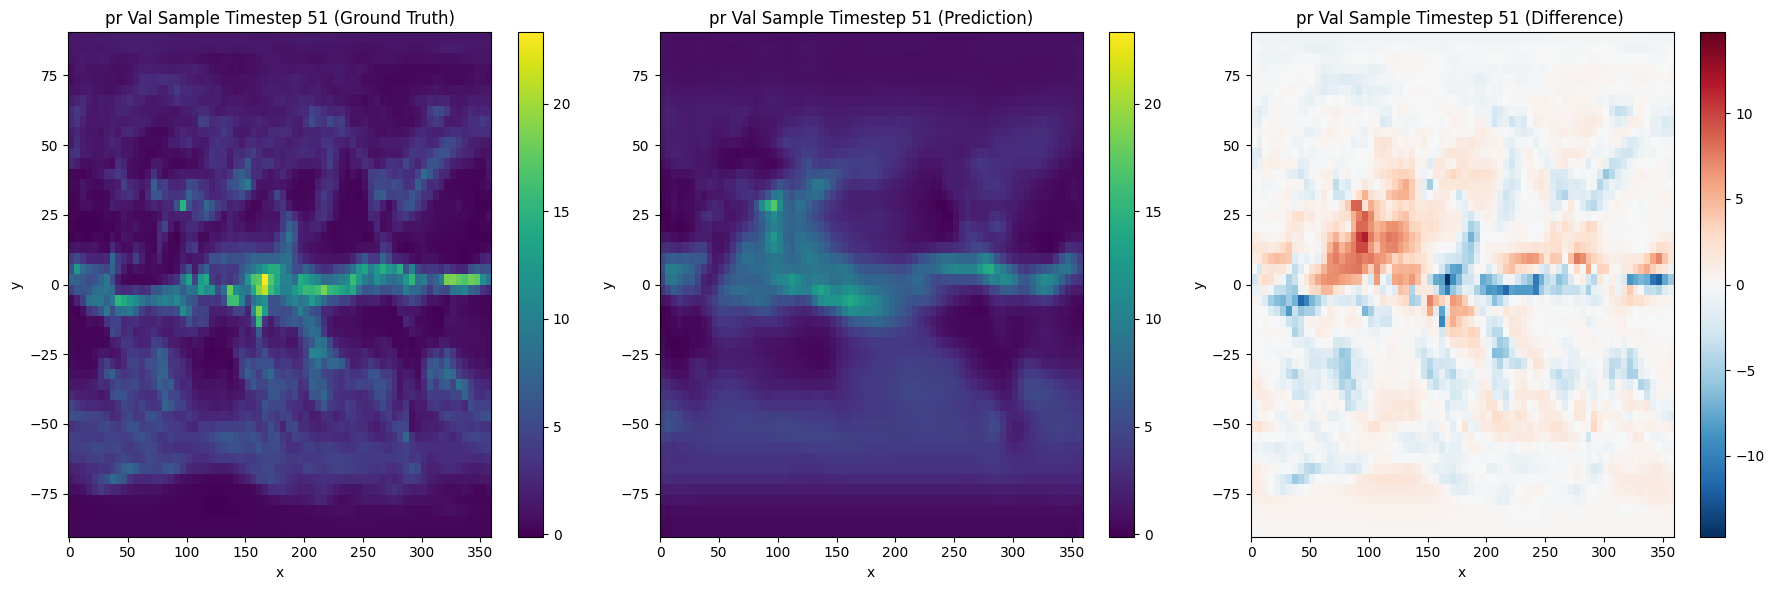

In [ ]:
# Load validation predictions

val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

# --- IMPORTANT: Ensure datamodule is defined and set up ---
if 'datamodule' in locals() and hasattr(datamodule, 'setup'):
    print("Running datamodule.setup() for plotting cell...")
    try:
        datamodule.setup(stage='fit')
    except Exception as e:
        print(f"Error during datamodule.setup(): {e}")
        print("Proceeding with plotting, but lat/lon might be missing if setup failed.")
else:
    print("WARNING: 'datamodule' object not found in the current scope, or it has no 'setup' method.")
    print("Plotting might fail or use incorrect coordinates/variables.")
    print("Please ensure the cell where 'datamodule' is initialized and used for training/testing has been run.")

# --- End of datamodule setup ---

# Now, try to get the coordinates and variables
try:
    lat, lon = datamodule.get_coords()
    output_vars = datamodule.output_vars
except AttributeError as e:
    print(f"AttributeError: Could not get attributes from datamodule: {e}")
    print("This usually means datamodule.setup() did not complete successfully or 'datamodule' is not the correct object.")
    print("Falling back to placeholder values for plotting to avoid crashing, but plots may be incorrect.")
    # Define fallback placeholder values if datamodule attributes are missing
    # For example:
    lat = np.linspace(-88.542, 88.542, 48)
    lon = np.linspace(0, 357.5, 72)
    output_vars = ['tas', 'pr']          # Default output variables
    print(f"Using placeholder lat: {lat.shape}, lon: {lon.shape}, output_vars: {output_vars}")
except NameError:
    print("ERROR: 'datamodule' is not defined. Please run the cell that defines and sets up the datamodule.")
    raise # Re-raise the NameError to stop if datamodule is essential


time = np.arange(val_preds.shape[0])

print(f"Plotting for output variables: {output_vars}")

for i, var in enumerate(output_vars):
    print(f"Processing variable: {var}")
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    print(f"Plotting Time-Mean for {var}...")
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    print(f"Plotting Time-Stddev for {var}...")
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    print(f"Plotting Random Timestep {t_idx} for {var}...")
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`.
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!


Loading dataset from: /content/cse-151B-Competition/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr
Dataset loaded successfully.
Plotted CO2 for ssp126
Plotted CO2 for ssp370
Plotted CO2 for ssp585


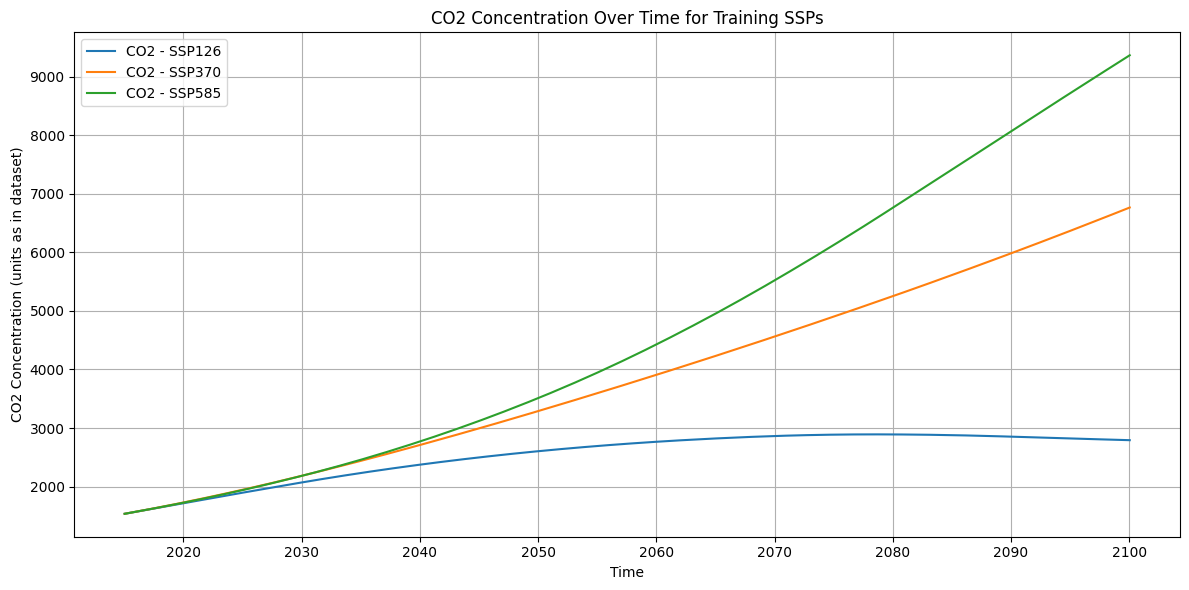

CO2 plot generated.


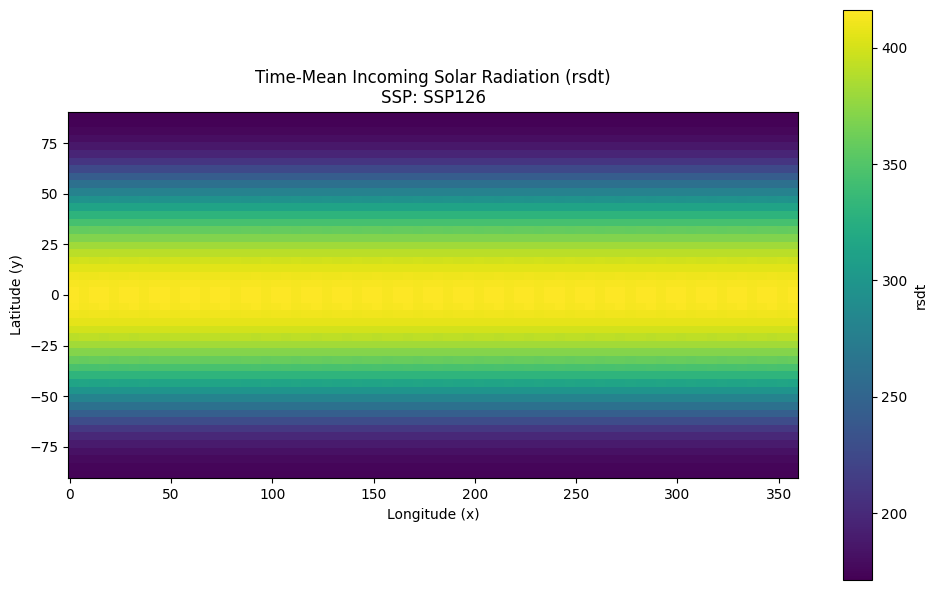

rsdt time-mean plot for ssp126 generated.


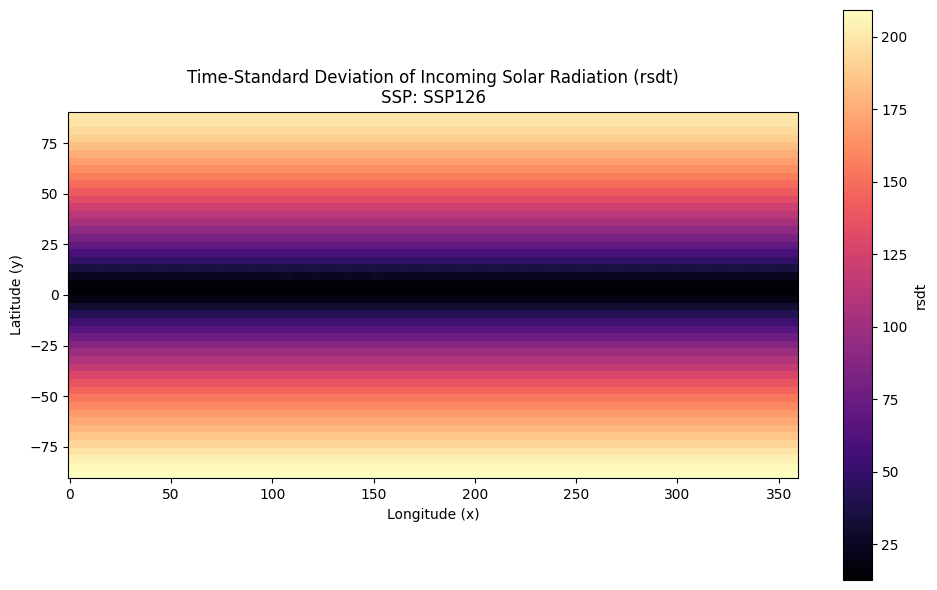

rsdt time-std plot for ssp126 generated.
Dataset closed.


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

config = {
    "data": {
        "path": "/content/cse-151B-Competition/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "target_member_id": 0,
    }
}
# --- End Configuration ---

ds_path = config["data"]["path"]
print(f"Loading dataset from: {ds_path}")
try:
    ds = xr.open_zarr(ds_path, consolidated=False)
    print("Dataset loaded successfully.")

    # --- 1. CO2 Concentration Over Time ---
    plt.figure(figsize=(12, 6))
    for ssp in config["data"]["train_ssps"]:
        try:
            co2_data = ds["CO2"].sel(ssp=ssp)
            time_coords = co2_data["time"].values

            # Attempt to convert cftime objects to pandas datetime for plotting
            # This handles common cftime types if present.
            if not isinstance(time_coords[0], np.datetime64):
                try:
                    # Generic conversion attempt using pandas
                    time_coords_datetime = pd.to_datetime(co2_data.time.astype(str).data)
                except Exception as e_cftime:
                    print(f"Initial time conversion for CO2 {ssp} failed, using numerical index. Error: {e_cftime}")
                    time_coords_datetime = np.arange(len(time_coords))
            else:
                time_coords_datetime = time_coords

            plt.plot(time_coords_datetime, co2_data.data.compute(), label=f"CO2 - {ssp.upper()}")
            print(f"Plotted CO2 for {ssp}")
        except Exception as e:
            print(f"Could not process CO2 for SSP {ssp}: {e}")

    plt.xlabel("Time")
    plt.ylabel("CO2 Concentration (units as in dataset)")
    plt.title("CO2 Concentration Over Time for Training SSPs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("CO2 plot generated.")

    # --- 2. Incoming Solar Radiation (rsdt) Spatial Maps ---
    ssp_for_rsdt = config["data"]["train_ssps"][0]

    try:
        # Select rsdt data for the chosen SSP
        # The structure of rsdt (global vs. spatial, member_id needed or not) can vary.
        # This attempts a flexible selection.
        if "member_id" in ds["rsdt"].dims and "member_id" in ds["rsdt"].sel(ssp=ssp_for_rsdt).coords:
             rsdt_ssp_data = ds["rsdt"].sel(ssp=ssp_for_rsdt, member_id=config["data"]["target_member_id"])
        else:
             rsdt_ssp_data = ds["rsdt"].sel(ssp=ssp_for_rsdt)

        # Rename dimensions if they are 'latitude'/'longitude' to 'y'/'x' for consistency
        if "latitude" in rsdt_ssp_data.dims and "longitude" in rsdt_ssp_data.dims:
            rsdt_ssp_data = rsdt_ssp_data.rename({"latitude": "y", "longitude": "x"})

        # Time-Mean rsdt
        rsdt_mean = rsdt_ssp_data.mean("time", skipna=True).compute()
        plt.figure(figsize=(10, 6))
        if 'y' in rsdt_mean.dims and 'x' in rsdt_mean.dims:
            rsdt_mean.plot(cmap="viridis", yincrease=True) # yincrease for conventional map orientation
            plt.xlabel("Longitude (x)")
            plt.ylabel("Latitude (y)")
            plt.gca().set_aspect('equal', adjustable='box')
        else: # Fallback for 1D or other rsdt structures
            rsdt_mean.plot()
        plt.title(f"Time-Mean Incoming Solar Radiation (rsdt)\nSSP: {ssp_for_rsdt.upper()}")
        plt.tight_layout()
        plt.show()
        print(f"rsdt time-mean plot for {ssp_for_rsdt} generated.")

        # Time-Standard Deviation rsdt
        rsdt_std = rsdt_ssp_data.std("time", skipna=True).compute()
        plt.figure(figsize=(10, 6))
        if 'y' in rsdt_std.dims and 'x' in rsdt_std.dims:
            rsdt_std.plot(cmap="magma", yincrease=True) # yincrease for conventional map orientation
            plt.xlabel("Longitude (x)")
            plt.ylabel("Latitude (y)")
            plt.gca().set_aspect('equal', adjustable='box')
        else: # Fallback
            rsdt_std.plot()
        plt.title(f"Time-Standard Deviation of Incoming Solar Radiation (rsdt)\nSSP: {ssp_for_rsdt.upper()}")
        plt.tight_layout()
        plt.show()
        print(f"rsdt time-std plot for {ssp_for_rsdt} generated.")

    except Exception as e:
        print(f"Could not process rsdt for SSP {ssp_for_rsdt}: {e}")

    ds.close()
    print("Dataset closed.")

except Exception as e:
    print(f"An error occurred during dataset loading or processing: {e}")
    if 'ds' in locals() and ds is not None:
        try:
            ds.close()
            print("Dataset closed due to error.")
        except Exception as e_close:
            print(f"Error closing dataset: {e_close}")


Loading dataset from: /content/cse-151B-Competition/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr
Dataset loaded successfully.
Latitude weights calculated.
Plotted CH4 for ssp126
Skipping SO2 for ssp126 as it's not a simple global time series in the Zarr structure.
Plotted CH4 for ssp370
Skipping SO2 for ssp370 as it's not a simple global time series in the Zarr structure.
Plotted CH4 for ssp585
Skipping SO2 for ssp585 as it's not a simple global time series in the Zarr structure.


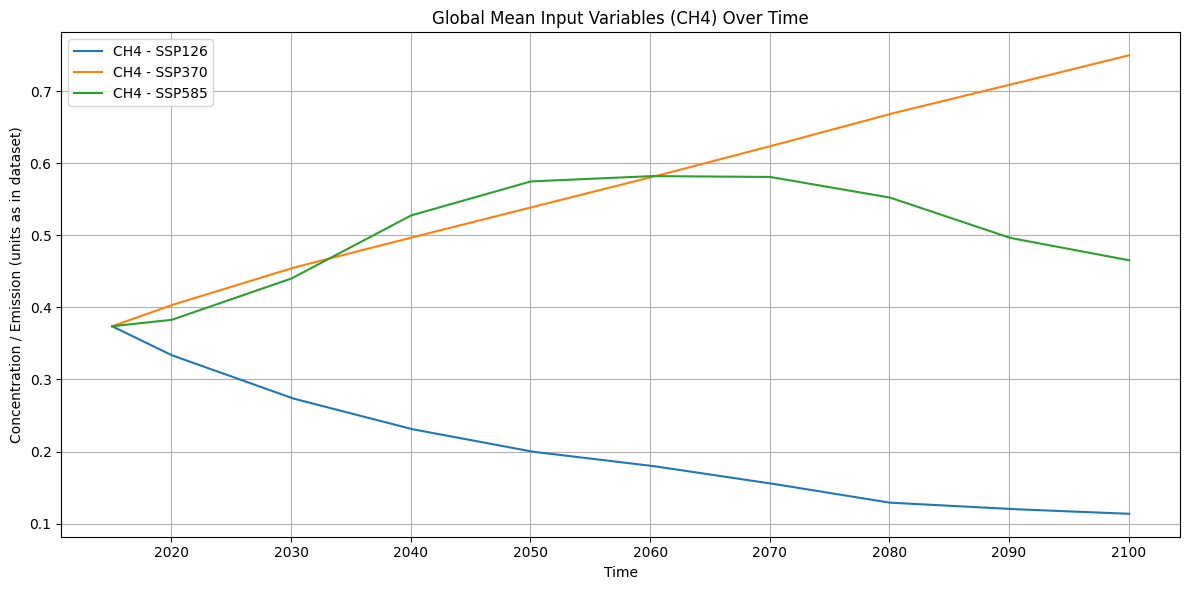

Input variables plot (CH4, SO2) generated.
Aligning latitude weights for tas - ssp126
Plotted Global Mean TAS for ssp126
Aligning latitude weights for tas - ssp370
Plotted Global Mean TAS for ssp370
Aligning latitude weights for tas - ssp585
Plotted Global Mean TAS for ssp585


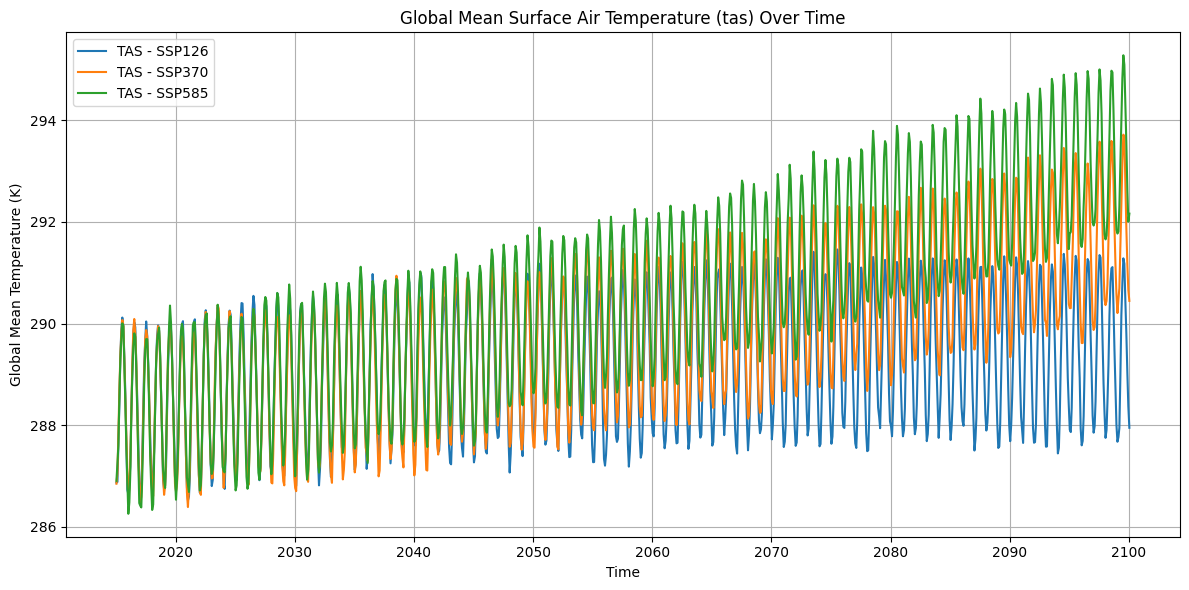

Global mean TAS plot generated.
Aligning latitude weights for pr - ssp126
Plotted Global Mean PR for ssp126
Aligning latitude weights for pr - ssp370
Plotted Global Mean PR for ssp370
Aligning latitude weights for pr - ssp585
Plotted Global Mean PR for ssp585


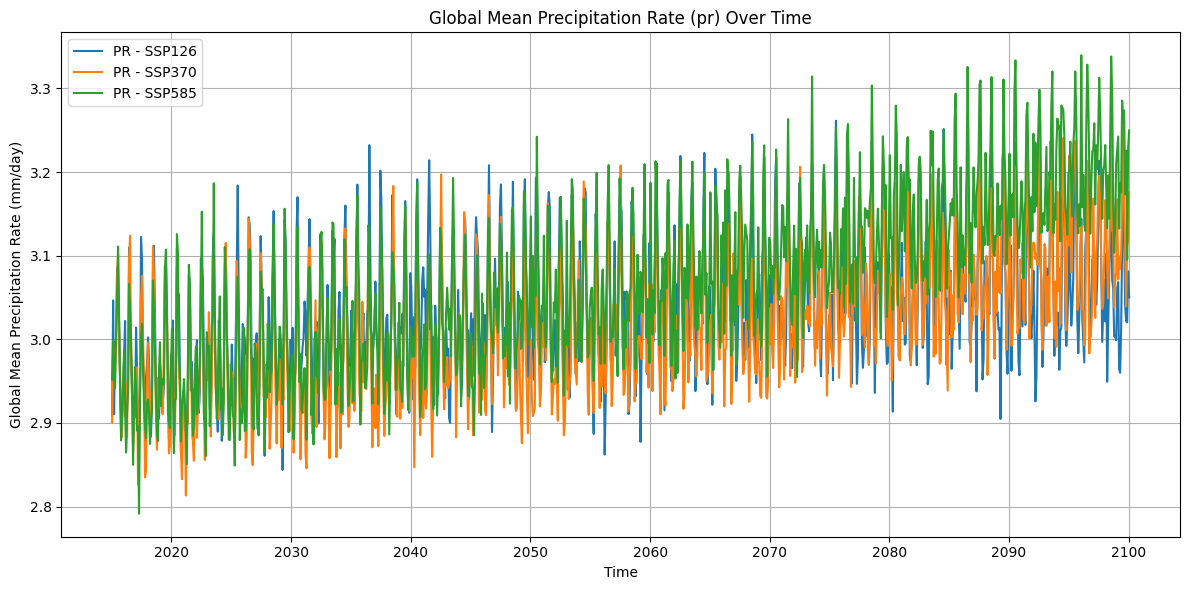

Global mean PR plot generated.
Dataset closed.


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

config = {
    "data": {
        "path": "/content/cse-151B-Competition/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "target_member_id": 0,
    }
}
# --- End Configuration ---

ds_path = config["data"]["path"]
print(f"Loading dataset from: {ds_path}")

def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

try:
    ds = xr.open_zarr(ds_path, consolidated=False)
    print("Dataset loaded successfully.")

    # Attempt to get latitude coordinates for weighting
    try:
        # Try fetching from a known spatial variable like 'rsdt' or 'tas'
        if 'rsdt' in ds:
            sample_spatial_var = ds['rsdt'].sel(ssp=config["data"]["train_ssps"][0], time=ds['rsdt'].time[0])
        elif 'tas' in ds:
            sample_spatial_var = ds['tas'].sel(ssp=config["data"]["train_ssps"][0], time=ds['tas'].time[0], member_id=config["data"]["target_member_id"])
        else:
            raise ValueError("Could not find a sample spatial variable to extract latitudes.")

        if "latitude" in sample_spatial_var.dims:
            lat_coords = sample_spatial_var.latitude.data
        elif "y" in sample_spatial_var.dims:
            lat_coords = sample_spatial_var.y.data
        else:
            raise ValueError("Latitude coordinates not found with expected dimension names ('latitude' or 'y').")
        lat_weights = xr.DataArray(get_lat_weights(lat_coords), dims=["y"], coords={"y": lat_coords})
        print("Latitude weights calculated.")
    except Exception as e:
        print(f"Warning: Could not calculate latitude weights: {e}. Spatial means will be unweighted.")
        lat_weights = None

    # --- 1. Global Mean CH4 and SO2 Over Time ---
    plt.figure(figsize=(12, 6))
    for ssp in config["data"]["train_ssps"]:
        for var_name in ["CH4", "SO2"]: 
            try:
                var_data = ds[var_name].sel(ssp=ssp)
                time_coords = var_data["time"].values
                if not isinstance(time_coords[0], np.datetime64):
                    try:
                        time_coords_datetime = pd.to_datetime(var_data.time.astype(str).data)
                    except Exception:
                        time_coords_datetime = np.arange(len(time_coords))
                else:
                    time_coords_datetime = time_coords


                if len(var_data.dims) == 1 and 'time' in var_data.dims:
                    global_mean_ts = var_data.data.compute()
                    plt.plot(time_coords_datetime, global_mean_ts, label=f"{var_name} - {ssp.upper()}")
                    print(f"Plotted {var_name} for {ssp}")
                else:
                    print(f"Skipping {var_name} for {ssp} as it's not a simple global time series in the Zarr structure.")

            except Exception as e:
                print(f"Could not process {var_name} for SSP {ssp}: {e}")

    plt.xlabel("Time")
    plt.ylabel("Concentration / Emission (units as in dataset)")
    plt.title("Global Mean Input Variables (CH4) Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Input variables plot (CH4, SO2) generated.")

    # --- 2. Global Mean Surface Air Temperature (tas) Over Time ---
    plt.figure(figsize=(12, 6))
    for ssp in config["data"]["train_ssps"]:
        try:
            tas_data = ds["tas"].sel(ssp=ssp, member_id=config["data"]["target_member_id"])
            if "latitude" in tas_data.dims and "longitude" in tas_data.dims:
                 tas_data = tas_data.rename({"latitude": "y", "longitude": "x"})

            time_coords = tas_data["time"].values
            if not isinstance(time_coords[0], np.datetime64):
                try:
                    time_coords_datetime = pd.to_datetime(tas_data.time.astype(str).data)
                except Exception:
                    time_coords_datetime = np.arange(len(time_coords))
            else:
                time_coords_datetime = time_coords

            if lat_weights is not None and 'y' in tas_data.dims and 'x' in tas_data.dims:
                # Ensure lat_weights are aligned if needed (xarray handles broadcasting by dimension name)
                if not lat_weights.y.equals(tas_data.y):
                    print(f"Aligning latitude weights for tas - {ssp}")
                    aligned_lat_weights = lat_weights.interp(y=tas_data.y)
                else:
                    aligned_lat_weights = lat_weights
                global_mean_tas = tas_data.weighted(aligned_lat_weights).mean(("x", "y")).compute()
            elif 'y' in tas_data.dims and 'x' in tas_data.dims: # Fallback to unweighted mean
                global_mean_tas = tas_data.mean(("x", "y")).compute()
            else: # Should not happen for tas if data is structured correctly
                print(f"tas for {ssp} does not have expected spatial dimensions.")
                continue

            plt.plot(time_coords_datetime, global_mean_tas, label=f"TAS - {ssp.upper()}")
            print(f"Plotted Global Mean TAS for {ssp}")
        except Exception as e:
            print(f"Could not process TAS for SSP {ssp}: {e}")

    plt.xlabel("Time")
    plt.ylabel("Global Mean Temperature (K)")
    plt.title("Global Mean Surface Air Temperature (tas) Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Global mean TAS plot generated.")

    # --- 3. Global Mean Precipitation Rate (pr) Over Time ---
    plt.figure(figsize=(12, 6))
    for ssp in config["data"]["train_ssps"]:
        try:
            pr_data = ds["pr"].sel(ssp=ssp, member_id=config["data"]["target_member_id"])
            if "latitude" in pr_data.dims and "longitude" in pr_data.dims:
                 pr_data = pr_data.rename({"latitude": "y", "longitude": "x"})

            time_coords = pr_data["time"].values
            if not isinstance(time_coords[0], np.datetime64):
                try:
                    time_coords_datetime = pd.to_datetime(pr_data.time.astype(str).data)
                except Exception:
                    time_coords_datetime = np.arange(len(time_coords))
            else:
                time_coords_datetime = time_coords

            if lat_weights is not None and 'y' in pr_data.dims and 'x' in pr_data.dims:
                if not lat_weights.y.equals(pr_data.y):
                    print(f"Aligning latitude weights for pr - {ssp}")
                    aligned_lat_weights = lat_weights.interp(y=pr_data.y)
                else:
                    aligned_lat_weights = lat_weights
                global_mean_pr = pr_data.weighted(aligned_lat_weights).mean(("x", "y")).compute()
            elif 'y' in pr_data.dims and 'x' in pr_data.dims: # Fallback to unweighted mean
                global_mean_pr = pr_data.mean(("x", "y")).compute()
            else: # Should not happen for pr if data is structured correctly
                print(f"pr for {ssp} does not have expected spatial dimensions.")
                continue

            plt.plot(time_coords_datetime, global_mean_pr, label=f"PR - {ssp.upper()}")
            print(f"Plotted Global Mean PR for {ssp}")
        except Exception as e:
            print(f"Could not process PR for SSP {ssp}: {e}")

    plt.xlabel("Time")
    plt.ylabel("Global Mean Precipitation Rate (mm/day)")
    plt.title("Global Mean Precipitation Rate (pr) Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Global mean PR plot generated.")

    ds.close()
    print("Dataset closed.")

except Exception as e:
    print(f"An error occurred during dataset loading or processing: {e}")
    if 'ds' in locals() and ds is not None:
        try:
            ds.close()
            print("Dataset closed due to error.")
        except Exception as e_close:
            print(f"Error closing dataset: {e_close}")

Potential log directories found under lightning_logs: ['lightning_logs/version_0', 'lightning_logs/version_1', 'lightning_logs/version_2', 'lightning_logs/version_3', 'lightning_logs/version_4', 'lightning_logs/version_5', 'lightning_logs/version_6']

Attempting to load logs from: lightning_logs/version_6
Found hparams.yaml in lightning_logs/version_6. Content snippet:
learning_rate: 0.001
...
No 'train/loss' or 'val/loss' tags found in lightning_logs/version_6.

Attempting to load logs from: lightning_logs/version_5
Found hparams.yaml in lightning_logs/version_5. Content snippet:
learning_rate: 0.001
...
No 'train/loss' or 'val/loss' tags found in lightning_logs/version_5.

Attempting to load logs from: lightning_logs/version_4
Found hparams.yaml in lightning_logs/version_4. Content snippet:
learning_rate: 0.001
...
No 'train/loss' or 'val/loss' tags found in lightning_logs/version_4.

Attempting to load logs from: lightning_logs/version_3
Found hparams.yaml in lightning_logs/version_

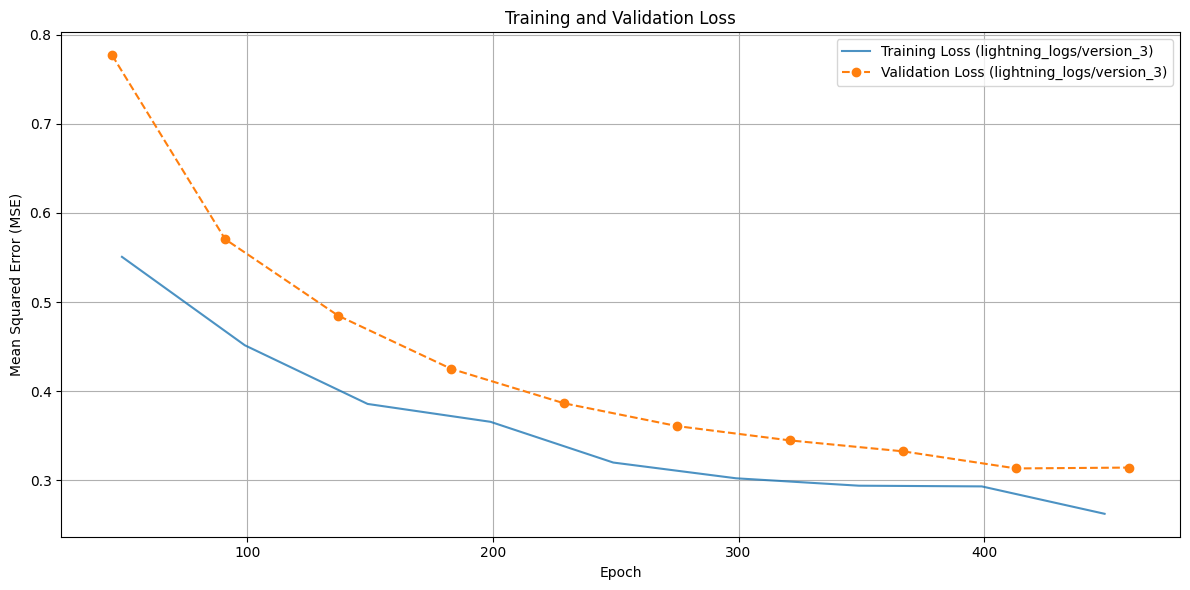

In [ ]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
import os
import numpy as np

# --- Configuration ---
# best_experiment_name = "DeeperCNN_Depth6_BS16"
log_dir_parent = "lightning_logs" # Changed to lightning_logs

# --- Function to load scalar data (remains the same) ---
def load_tensorboard_scalars(logdir, scalar_tags):
    ea = event_accumulator.EventAccumulator(logdir, size_guidance={event_accumulator.SCALARS: 0})
    ea.Reload()
    scalar_data = {}
    available_tags = ea.Tags()['scalars']
    for tag in scalar_tags:
        if tag in available_tags:
            events = ea.Scalars(tag)
            scalar_data[tag] = [(event.step, event.value) for event in events]
        else:
            print(f"Warning: Tag '{tag}' not found in scalars for logdir '{logdir}'. Available tags: {available_tags}")
            scalar_data[tag] = []
    return scalar_data

# --- Find and Plot Loss Data from lightning_logs ---
event_file_found = False
potential_log_dirs = []

if os.path.exists(log_dir_parent):

    for item in sorted(os.listdir(log_dir_parent)):
        if item.startswith("version_") and os.path.isdir(os.path.join(log_dir_parent, item)):
            potential_log_dirs.append(os.path.join(log_dir_parent, item))

        elif item == "DeeperCNN_Depth6_BS16" and os.path.isdir(os.path.join(log_dir_parent, item)):
            deeper_cnn_path = os.path.join(log_dir_parent, item)
            for version_dir in sorted(os.listdir(deeper_cnn_path)):
                 if version_dir.startswith("version_"):
                    potential_log_dirs.append(os.path.join(deeper_cnn_path, version_dir))


    print(f"Potential log directories found under {log_dir_parent}: {potential_log_dirs}")

    for log_dir_path_attempt in reversed(potential_log_dirs): # Try newest versions first
        print(f"\nAttempting to load logs from: {log_dir_path_attempt}")
        # Check for hparams.yaml to see if it matches the experiment
        hparams_path = os.path.join(log_dir_path_attempt, "hparams.yaml")
        if os.path.exists(hparams_path):
            print(f"Found hparams.yaml in {log_dir_path_attempt}. Content snippet:")
            try:
                with open(hparams_path, 'r') as f:
                    print(f.read(200) + "...") # Print first 200 chars

            except Exception as e:
                print(f"Could not read hparams.yaml: {e}")
        else:
            print(f"No hparams.yaml found in {log_dir_path_attempt}")


        tags_to_load = ['train/loss', 'val/loss', 'epoch'] # Added epoch to help align
        scalar_values = load_tensorboard_scalars(log_dir_path_attempt, tags_to_load)

        if scalar_values.get('train/loss') or scalar_values.get('val/loss'):
            print(f"Successfully loaded some scalar data from {log_dir_path_attempt}.")
            event_file_found = True

            plt.figure(figsize=(12, 6))

            epochs = None
            if scalar_values.get('epoch'):
                _, epochs = zip(*scalar_values['epoch'])
                # Tensorboard epoch usually logs at the end of validation.
                # So, number of val_loss points == number of epoch points

            # Plot Training Loss
            if scalar_values.get('train/loss'):
                steps_train, train_loss = zip(*scalar_values['train/loss'])
                # If train_loss is per step, and val_loss per epoch, this needs careful alignment.

                plt.plot(steps_train, train_loss, label=f'Training Loss ({log_dir_path_attempt})', alpha=0.8)
            else:
                print(f"No 'train/loss' data in {log_dir_path_attempt}.")

            # Plot Validation Loss
            if scalar_values.get('val/loss'):
                steps_val, val_loss = zip(*scalar_values['val/loss'])
                # Use epoch numbers for x-axis if available and lengths match
                x_axis_val = epochs if epochs and len(epochs) == len(val_loss) else steps_val
                plt.plot(x_axis_val, val_loss, label=f'Validation Loss ({log_dir_path_attempt})', linestyle='--', marker='o')
            else:
                print(f"No 'val/loss' data in {log_dir_path_attempt}.")

            plt.title(f'Training and Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Mean Squared Error (MSE)')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            break # Stop after plotting the first one found
        else:
            print(f"No 'train/loss' or 'val/loss' tags found in {log_dir_path_attempt}.")

if not event_file_found:
    print(f"\nERROR: Could not find relevant event files with 'train/loss' or 'val/loss' in '{log_dir_parent}' or its subdirectories.")
    print("Please verify:")
    print("1. The `log_dir_parent` is correct.")
    print("2. Experiments were run with a Pytorch Lightning logger enabled.")
    print("3. The logger was configured to save 'train/loss' and 'val/loss' (or similar tags).")
    print("4. The `name` parameter in `TensorBoardLogger(save_dir, name=...)` ")


Initializing DataModule for high-error sample analysis...
Creating dataset with 2943 samples...
Creating dataset with 120 samples...
Loading test data for ssp245, member_id: 0
Loading test data for ssp245, member_id: 1
Loading test data for ssp245, member_id: 2
Creating dataset with 360 samples...
Loading model from checkpoint: checkpoints/DeeperCNN_Depth6_BS16/DeeperCNN_Depth6_BS16-best-epoch=09-val/loss=0.1947.ckpt
Calculating losses for 2943 training samples...
Processed 500/2943 samples...
Processed 1000/2943 samples...
Processed 1500/2943 samples...
Processed 2000/2943 samples...
Processed 2500/2943 samples...
Loss calculation complete.

Visualizing top 3 training samples with highest error:

Rank 1 high-error sample (index 696), Loss: 0.4367


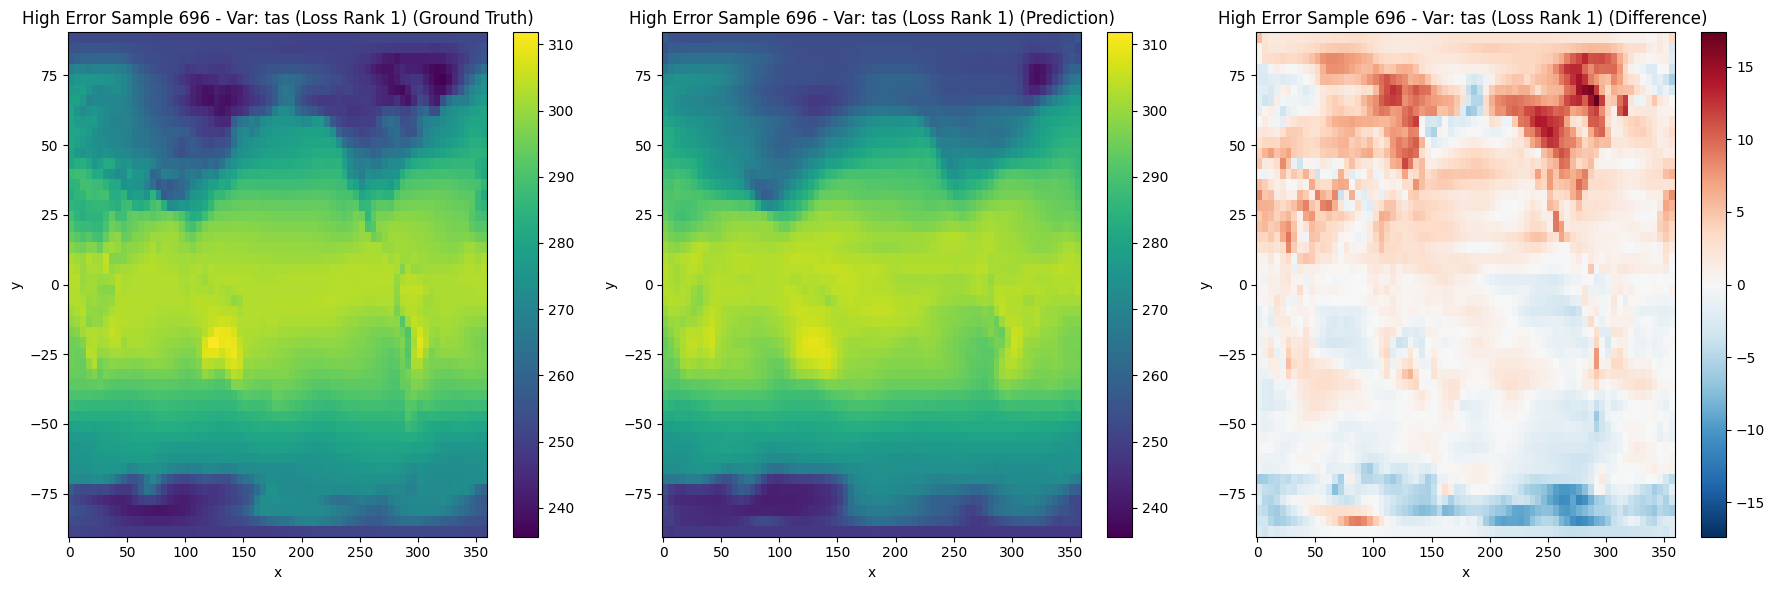

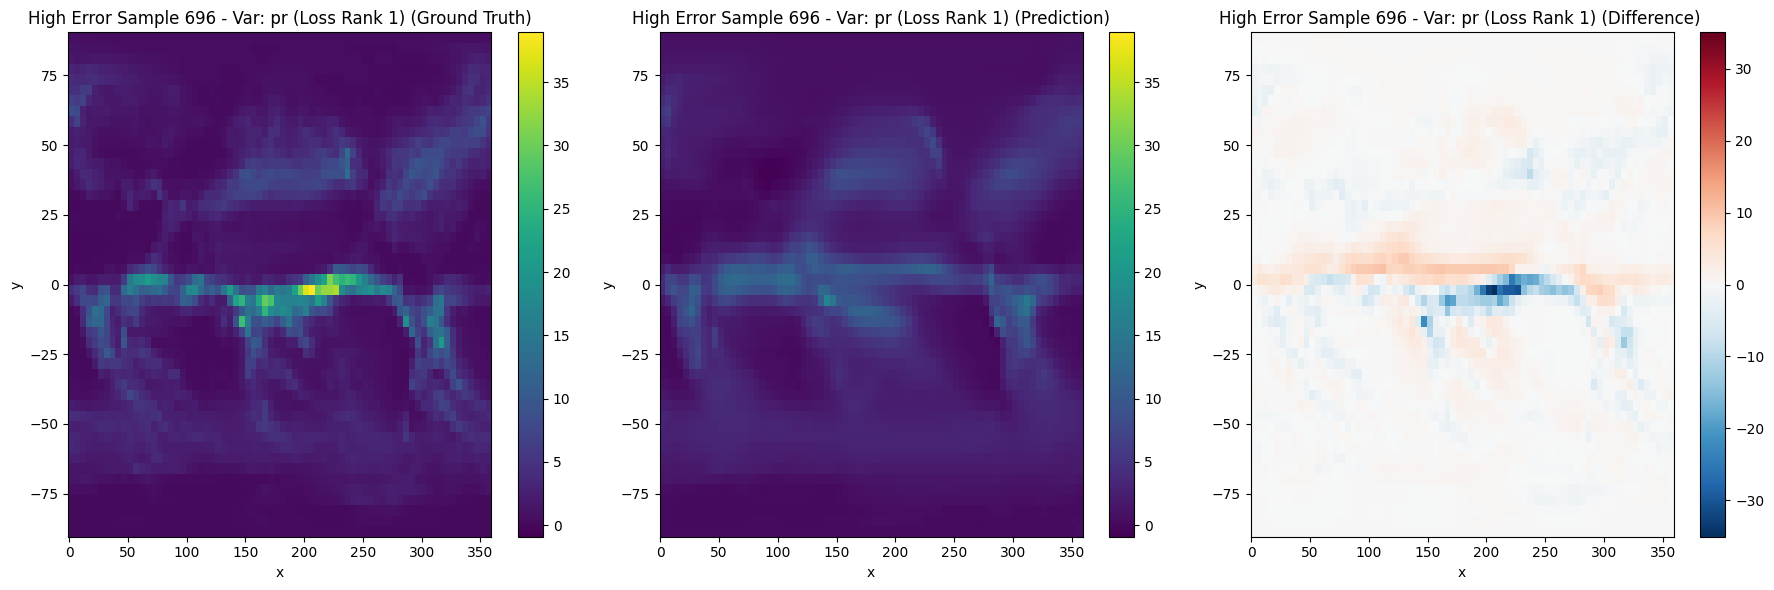

--------------------------------------------------
Rank 2 high-error sample (index 2594), Loss: 0.4177


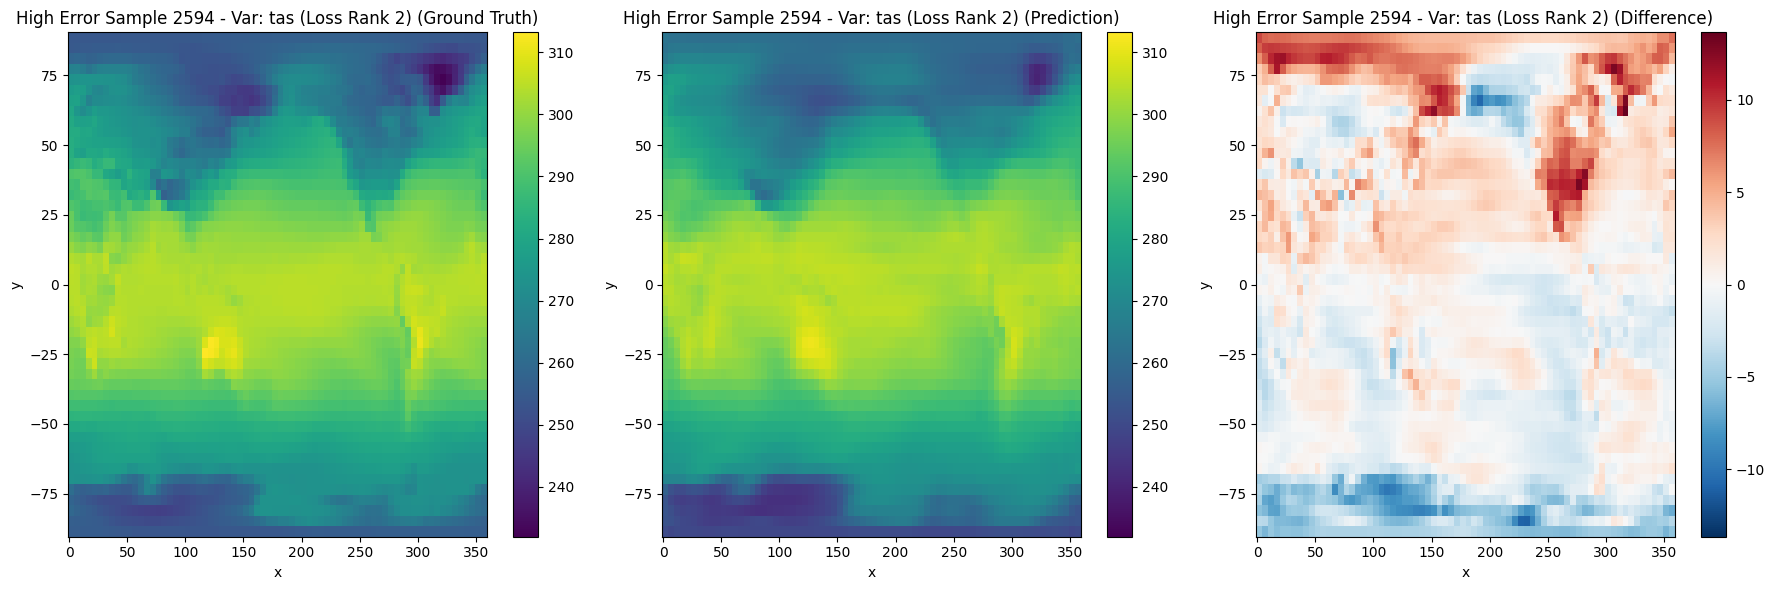

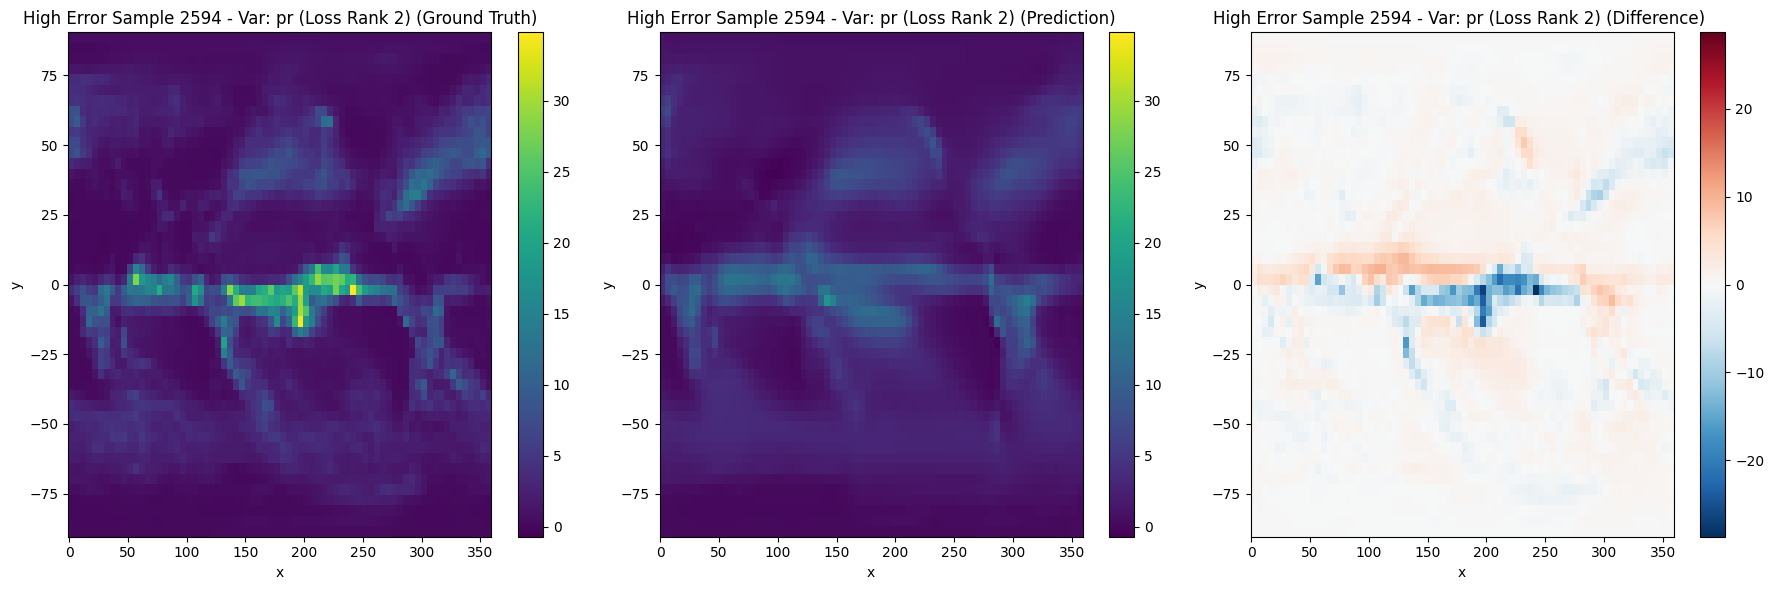

--------------------------------------------------
Rank 3 high-error sample (index 1489), Loss: 0.4141


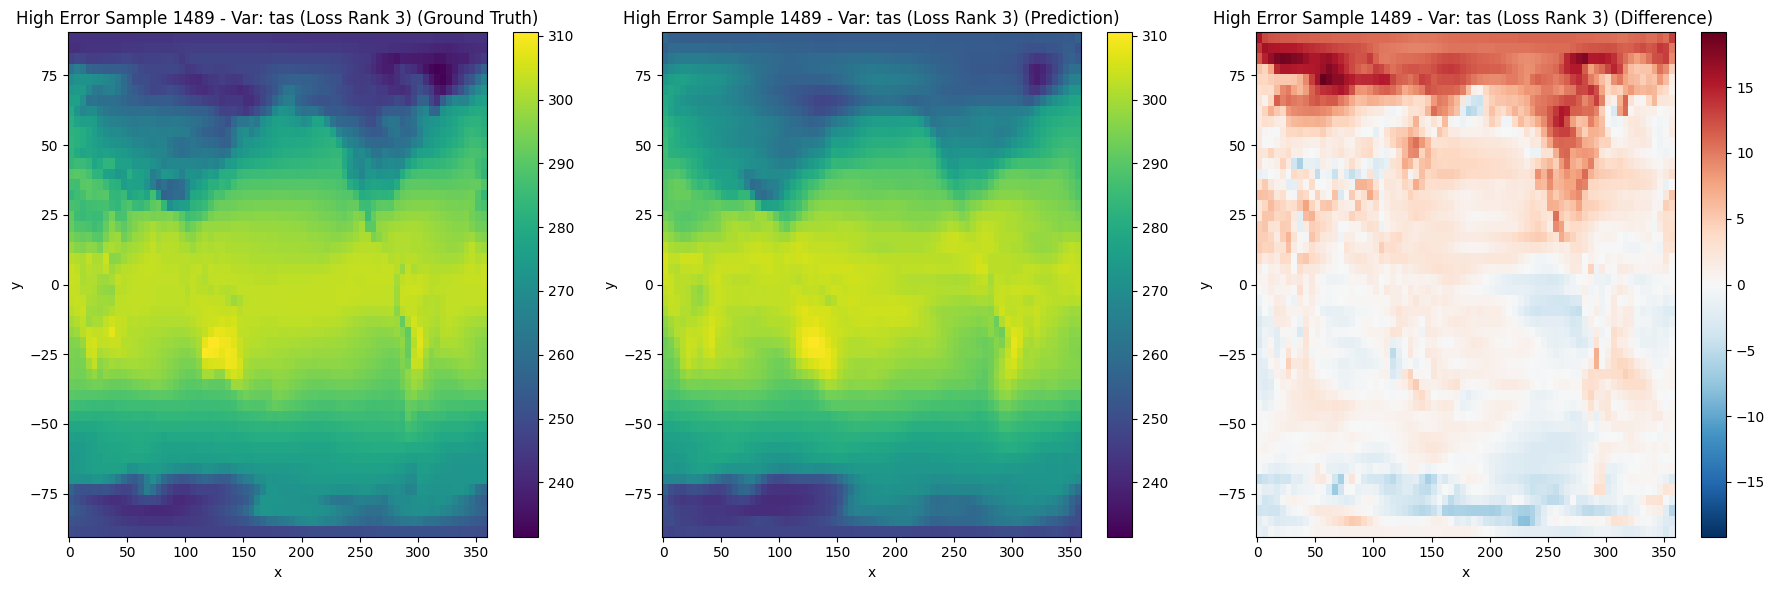

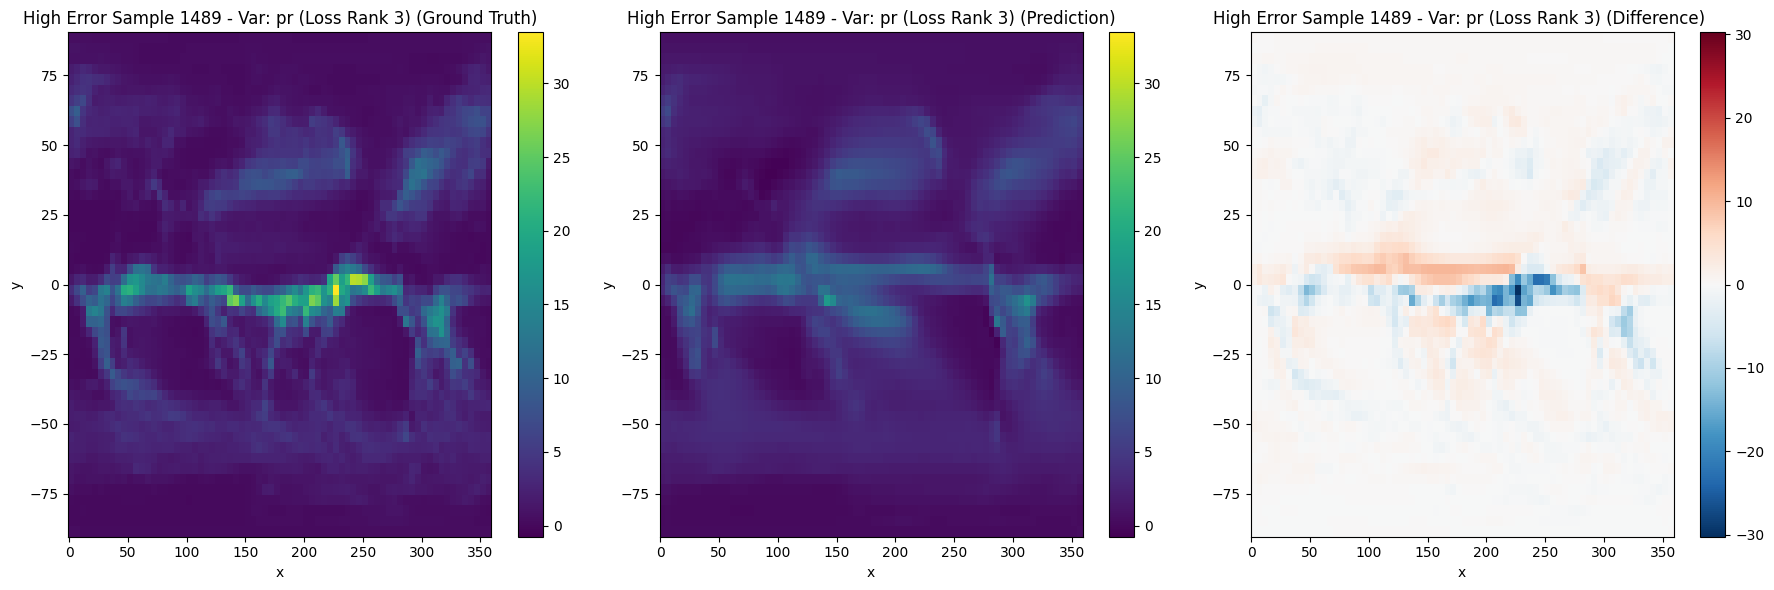

--------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import torch
# Ensure 'datamodule_analysis', 'lightning_module_best', 'train_dataset_inputs',
# 'train_dataset_outputs', 'normalizer', 'output_vars', 'lat', 'lon',
# 'plot_comparison', 'config_exp1' are defined from previous cells.

# --- Configuration for High-Error Sample Analysis ---
config_to_test_viz = config_exp1
checkpoint_path_viz = f"checkpoints/{config_to_test_viz.get('experiment_name')}/{config_to_test_viz.get('experiment_name')}-best-epoch=09-val/loss=0.1947.ckpt"


# --- (Re)Initialize DataModule if needed for lat/lon and normalizer ---
print("Initializing DataModule for high-error sample analysis...")
datamodule_analysis = ClimateDataModule(**config_to_test_viz["data"])
datamodule_analysis.setup(stage='fit')
normalizer = datamodule_analysis.normalizer
lat, lon = datamodule_analysis.get_coords()
output_vars = datamodule_analysis.output_vars

# --- Load the best model ---
print(f"Loading model from checkpoint: {checkpoint_path_viz}")
model_for_viz = SimpleCNN(
    n_input_channels=len(config_to_test_viz["data"]["input_vars"]),
    n_output_channels=len(config_to_test_viz["data"]["output_vars"]),
    **{k: v for k, v in config_to_test_viz["model"].items() if k != "type"}
)
lightning_module_best = ClimateEmulationModule.load_from_checkpoint(
    checkpoint_path_viz,
    model=model_for_viz,
)
lightning_module_best.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lightning_module_best.to(device)

# --- Get all training data (normalized) ---
if not hasattr(datamodule_analysis, 'train_dataset') or not datamodule_analysis.train_dataset:
    print("Re-creating train_dataset as it's not directly available from datamodule_analysis or is empty.")
    datamodule_analysis.setup(stage='fit')

train_dataset_inputs = torch.stack([datamodule_analysis.train_dataset[i][0] for i in range(len(datamodule_analysis.train_dataset))])
train_dataset_outputs = torch.stack([datamodule_analysis.train_dataset[i][1] for i in range(len(datamodule_analysis.train_dataset))])

# --- Calculate losses for all training samples ---
print(f"Calculating losses for {len(train_dataset_inputs)} training samples...")
losses = []
with torch.no_grad():
    for i in range(len(train_dataset_inputs)):
        x_norm_sample = train_dataset_inputs[i]
        y_true_norm_sample = train_dataset_outputs[i]

        y_pred_norm_sample = lightning_module_best.model(x_norm_sample.unsqueeze(0).to(device)).squeeze(0).cpu()

        loss = torch.mean((y_pred_norm_sample - y_true_norm_sample)**2)
        losses.append(loss.item())
        if (i+1) % 500 == 0:
            print(f"Processed {i+1}/{len(train_dataset_inputs)} samples...")
print("Loss calculation complete.")

losses = np.array(losses)
top_k_indices = np.argsort(losses)[::-1]

# --- Visualize top K high-error samples ---
K_samples_to_plot = 3
print(f"\nVisualizing top {K_samples_to_plot} training samples with highest error:\n")

for rank, sample_idx in enumerate(top_k_indices[:K_samples_to_plot]):
    print(f"Rank {rank+1} high-error sample (index {sample_idx}), Loss: {losses[sample_idx]:.4f}")

    x_norm_sample = train_dataset_inputs[sample_idx]
    y_true_norm_sample = train_dataset_outputs[sample_idx]

    with torch.no_grad():
        y_pred_norm_sample = lightning_module_best.model(x_norm_sample.unsqueeze(0).to(device)).squeeze(0).cpu()

    # Denormalize outputs
    # y_true_norm_sample.cpu().numpy() is (num_vars, H, W)
    # normalizer.inverse_transform_output returns (1, num_vars, H, W) due to broadcasting
    y_true_denorm_raw = normalizer.inverse_transform_output(y_true_norm_sample.cpu().numpy())
    y_pred_denorm_raw = normalizer.inverse_transform_output(y_pred_norm_sample.cpu().numpy())

    # Squeeze the leading singleton (batch-like) dimension
    y_true_denorm = y_true_denorm_raw.squeeze(0) if y_true_denorm_raw.ndim == 4 and y_true_denorm_raw.shape[0] == 1 else y_true_denorm_raw
    y_pred_denorm = y_pred_denorm_raw.squeeze(0) if y_pred_denorm_raw.ndim == 4 and y_pred_denorm_raw.shape[0] == 1 else y_pred_denorm_raw

    # Now y_true_denorm and y_pred_denorm should be (num_output_vars, H, W), e.g. (2, 48, 72)
    if not (y_true_denorm.ndim == 3 and y_true_denorm.shape[0] == len(output_vars)):
         raise ValueError(f"Unexpected shape for y_true_denorm: {y_true_denorm.shape}. Expected ({len(output_vars)}, H, W)")
    if not (y_pred_denorm.ndim == 3 and y_pred_denorm.shape[0] == len(output_vars)):
         raise ValueError(f"Unexpected shape for y_pred_denorm: {y_pred_denorm.shape}. Expected ({len(output_vars)}, H, W)")

    # Visualize each output variable (tas, pr)
    for var_idx, var_name in enumerate(output_vars):
        current_true_data = y_true_denorm[var_idx] # Should be (H, W)
        current_pred_data = y_pred_denorm[var_idx] # Should be (H, W)

        if current_true_data.ndim != 2:
             raise ValueError(f"Data for true_xr_sample (var: {var_name}) is not 2D. Shape: {current_true_data.shape}")
        if current_pred_data.ndim != 2:
             raise ValueError(f"Data for pred_xr_sample (var: {var_name}) is not 2D. Shape: {current_pred_data.shape}")

        true_xr_sample = xr.DataArray(current_true_data, dims=["y", "x"], coords={"y": lat, "x": lon})
        pred_xr_sample = xr.DataArray(current_pred_data, dims=["y", "x"], coords={"y": lat, "x": lon})

        plot_comparison(
            true_xr_sample,
            pred_xr_sample,
            title=f"High Error Sample {sample_idx} - Var: {var_name} (Loss Rank {rank+1})"
        )
    print("-" * 50)